# History Matching/EKI Comparison work
In this notebook we present the relevant figures that compare the history matching approach to the EKI approach. 

In [3]:
import config 
import os 
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from glob import glob 
from joblib import Parallel,delayed,load
from qbo_utils.qbo_ref import get_reference_qbo,fetch_qbo_file

BASE_EKI_EXPERIMENTS = { ## UPDATE PATHS with experiment result paths
    '5': '/Users/robcking/PhD/EKIDATA/N5',
    '10': '/Users/robcking/PhD/EKIDATA/N10',
    '20': '/Users/robcking/PhD/EKIDATA/N20',
    '50': '/Users/robcking/PhD/EKIDATA/N50',
}

BASE_HM_EXPERIMENTS = {
    '5':'/Users/robcking/PhD/history_matching_data/new/5_sample_exp',
    '10':'/Users/robcking/PhD/history_matching_data/new/10_sample_exp',
    '20':'/Users/robcking/PhD/history_matching_data/new/20_sample_exp',
    '50':'/Users/robcking/PhD/history_matching_data/new/50_sample_exp'
}

period,perioderr,amplitude,amplituderr= get_reference_qbo(fetch_qbo_file(local_path='./qbo.dat'))

## History Matching Centroid Evolution
Similar to the centroid evolution presented in the EKI convergence notebook, we present the equivalent plot for history matching

In [6]:
def get_hm_centroids(hm_n:int):
    centroids = []
    spaces = sorted(
        glob(
            os.path.join(BASE_HM_EXPERIMENTS[str(hm_n)],'*.space')
            ),
        key=lambda x: re.search(r'\d+(?=.space)',x).group())
    for f in spaces:
        x = load(f).to_xarray().astype(int)
        denom = x.integrate(coord=('cwtropics','Bt_eq'))
        centroids.append([(x.cwtropics*x).integrate(coord=('cwtropics','Bt_eq'))/denom,(x.Bt_eq*x).integrate(coord=('cwtropics','Bt_eq'))/denom])
    return np.array(centroids)

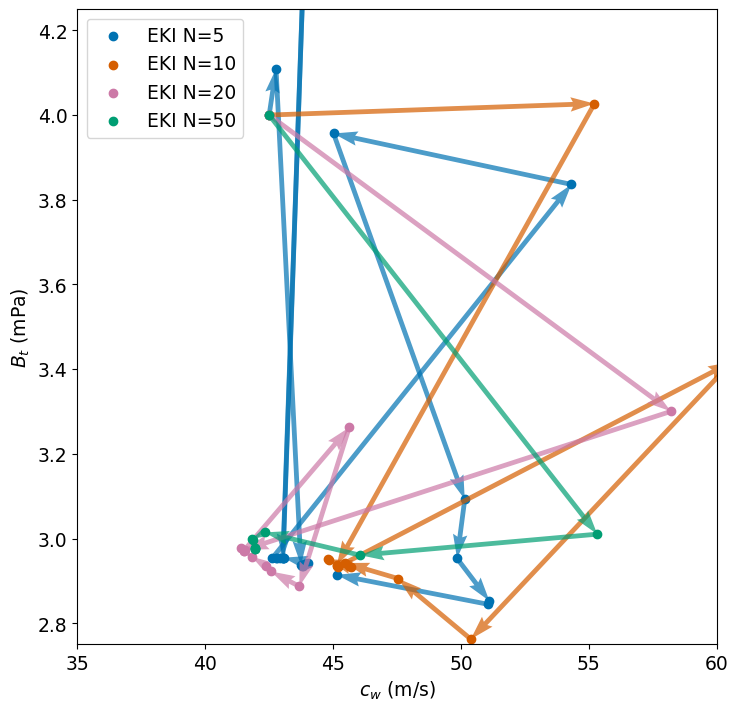

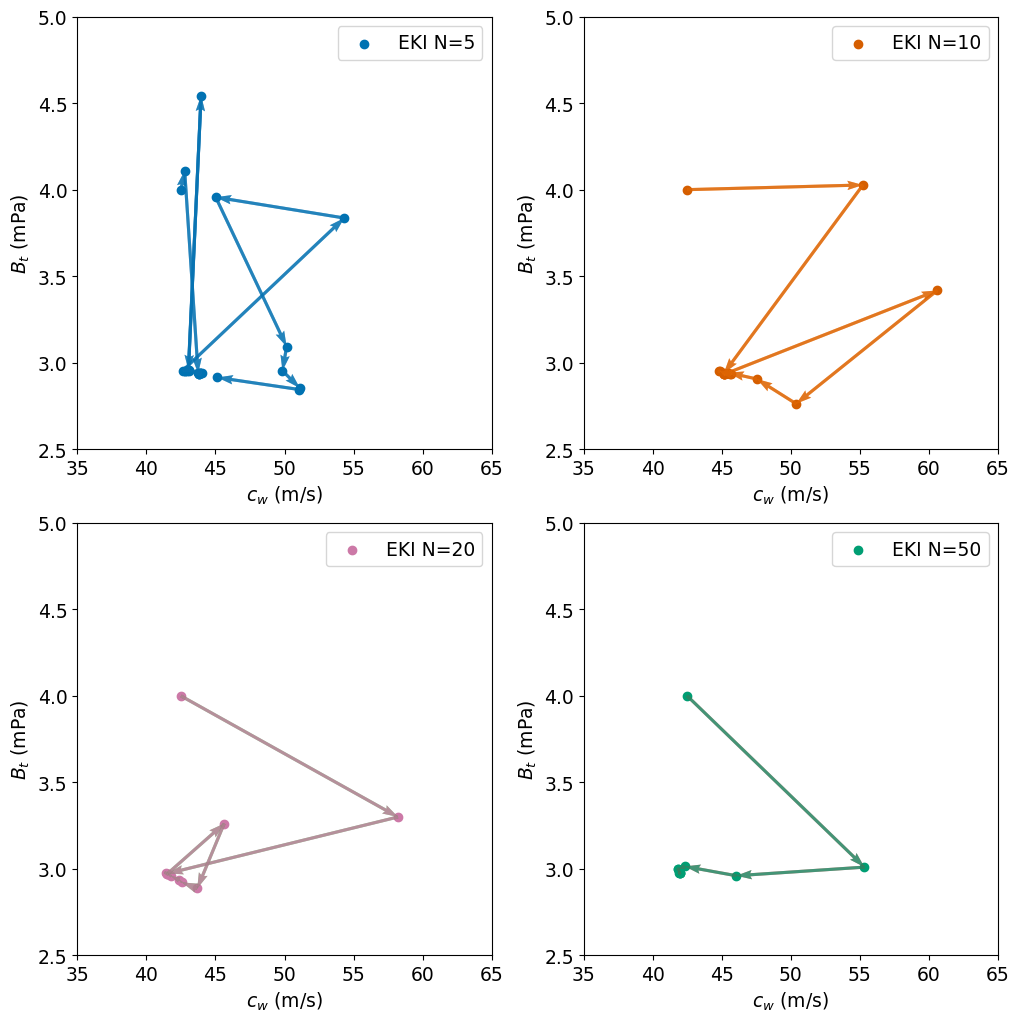

In [7]:
hm_centroid_update = []
marker = ['o','o','o','o']
combfig,combaxs = plt.subplots(figsize=(8.25,8.25))
figs,axs = plt.subplots(2,2,figsize=(10.5,10.5))
figs.tight_layout(pad=2)
for (i,n),ax in zip(enumerate([5,10,20,50]),axs.ravel()):

    hm_centroid_update_n = []
    nroy_centroids = get_hm_centroids(n)
    ax.scatter(nroy_centroids[:,0],nroy_centroids[:,1]*1000,label=f'EKI N={n}',marker=marker[i],c=config.COLORS[str(n)],alpha=1.0)
    combaxs.scatter(nroy_centroids[:,0],nroy_centroids[:,1]*1000,label=f"EKI N={n}",marker=marker[i],c=config.COLORS[str(n)],alpha=1.0)
 
    for start,stop in zip(nroy_centroids[:-1],nroy_centroids[1:]):
        hm_centroid_update_n.append(np.sqrt(((stop[0]-start[0])/75)**2 + ((stop[1] -start[1])/0.006)**2))     
        ax.quiver(start[0],1000*start[1],stop[0] - start[0],1000*(stop[1] - start[1]),angles='xy',scale_units='xy',scale=1.0,alpha=0.6,color=f'C{i}')
        ax.quiver(start[0],1000*start[1],stop[0] - start[0],1000*(stop[1] - start[1]),angles='xy',scale_units='xy',scale=1.0,alpha=0.7,color=config.COLORS[str(n)])
        combaxs.quiver(start[0],1000*start[1],stop[0] - start[0],1000*(stop[1] - start[1]),angles='xy',scale_units='xy',scale=1.0,alpha=0.7,color=config.COLORS[str(n)])
    hm_centroid_update.append(hm_centroid_update_n)
    # plt.legend()
    ax.set_xlabel("$c_w$ (m/s)")
    ax.set_ylabel("$B_t$ (mPa)")
    ax.set_xlim(35,65)
    ax.set_ylim(2.5,5)
    ax.legend()
combaxs.legend()
combaxs.set_xlabel("$c_w$ (m/s)")
combaxs.set_ylabel("$B_t$ (mPa)")
combaxs.set_xlim(35,60)
combaxs.set_ylim(2.75,4.25)
figs.savefig(f'figures/hm_centroids_onefig.png',dpi=230,bbox_inches='tight')
combfig.savefig(f'figures/hm_centroids.png',dpi=230,bbox_inches='tight')




## History Matching/EKI convergence comparison

In [ ]:
FILES = '/Users/robcking/PhD/history_matching_data/new/'

def get_all_samples(dir,n,nd=2):
    nsamples = len(glob(os.path.join(dir,'*.csv')))
    return np.array([pd.read_csv(os.path.join(dir,f'{p}_samples.csv'),index_col='run_id').to_numpy() for p in range(nsamples)])

def centroid(s):
    sxr = s.to_xarray().astype(int)
    denom = sxr.integrate(coord=s.coord_labels)
    return np.array(
        [
            (sxr[c] * sxr).integrate(coord=s.coord_labels) / denom
            for c in s.coord_labels
        ]
    )

def per_s(s,N_samples=10000):
    sxr = s.to_xarray()
    dx = (sxr.cwtropics.max() - sxr.cwtropics.min())/sxr.cwtropics.size
    dy = (sxr.Bt_eq.max() - sxr.Bt_eq.min())/sxr.Bt_eq.size
    area = 100*float(dx*dy*sxr.sum())/float(75*0.006)
    samples = s.uniform(n_samples=N_samples)
    norm_residuals = ((samples - centroid(s)))/np.array([75,0.006])
    avgspread = np.sqrt(np.mean(np.sum(norm_residuals**2,axis=-1)))
    return area,avgspread

def get_areas_and_spreads(n,N_samples=10000):
    path = os.path.join(FILES,f'{n}_sample_exp')
    space = [load(os.path.join(path,f'{p}.space')) for p in range(len(glob(os.path.join(path,'*.space'))))]
    arearmse = np.array(Parallel(n_jobs=-1, verbose=100)(delayed(per_s)(s,N_samples=N_samples) for s in space))
    arearmse[0,1] = np.sqrt(1/6)
    arearmse[0,0] = 100
    return arearmse[:,0],arearmse[:,1]
